# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=1, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
        
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    x1 = encoder_block(inputs, 16, 2)
    x2 = encoder_block(x1, 32, 2)
    x3 = encoder_block(x2, 64, 2)
    x4 = encoder_block(x3, 128, 2)
    x5 = encoder_block(x4, 256, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    x5_5 = conv2d_batchnorm(x5,256,kernel_size=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x = decoder_block(x5_5, x4, 256)
    x = decoder_block(x, x3, 128)
    x = decoder_block(x, x2, 64)
    x = decoder_block(x, x1, 32)
    x = decoder_block(x, inputs, 16)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.001 # 0.0001 - slow
batch_size = 256 #512/384 => Exhaust resources
num_epochs = 100
steps_per_epoch = 40 #200
validation_steps = 5 #50
workers = 4

Epoch 1/100
39/40 [============================>.] - ETA: 3s - loss: 1.0883

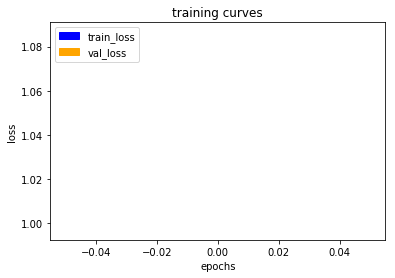

40/40 [==============================] - 144s - loss: 1.0847 - val_loss: 0.9970
Epoch 2/100
39/40 [============================>.] - ETA: 3s - loss: 0.8450

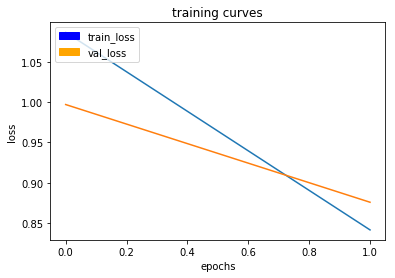

40/40 [==============================] - 139s - loss: 0.8422 - val_loss: 0.8760
Epoch 3/100
39/40 [============================>.] - ETA: 3s - loss: 0.6223

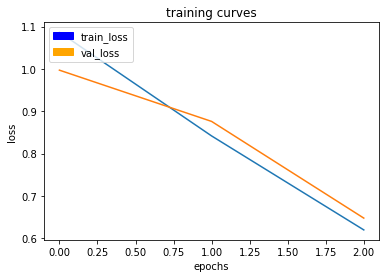

40/40 [==============================] - 140s - loss: 0.6193 - val_loss: 0.6478
Epoch 4/100
39/40 [============================>.] - ETA: 3s - loss: 0.4009

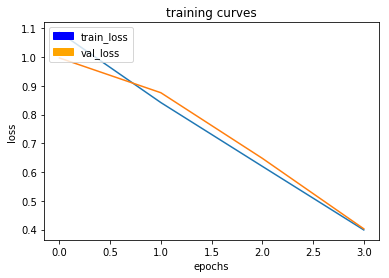

40/40 [==============================] - 143s - loss: 0.3986 - val_loss: 0.4025
Epoch 5/100
39/40 [============================>.] - ETA: 3s - loss: 0.2460

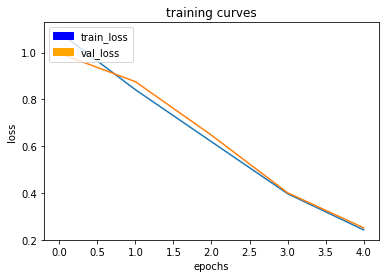

40/40 [==============================] - 140s - loss: 0.2447 - val_loss: 0.2532
Epoch 6/100
39/40 [============================>.] - ETA: 3s - loss: 0.1607

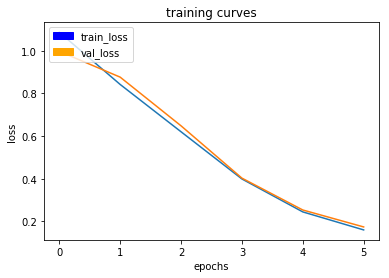

40/40 [==============================] - 139s - loss: 0.1599 - val_loss: 0.1737
Epoch 7/100
39/40 [============================>.] - ETA: 3s - loss: 0.1125

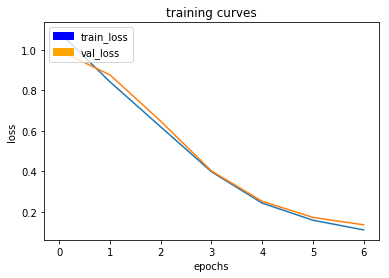

40/40 [==============================] - 142s - loss: 0.1120 - val_loss: 0.1371
Epoch 8/100
39/40 [============================>.] - ETA: 3s - loss: 0.0840

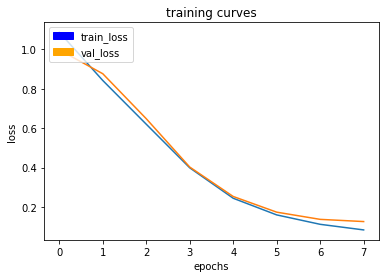

40/40 [==============================] - 140s - loss: 0.0838 - val_loss: 0.1260
Epoch 9/100
39/40 [============================>.] - ETA: 3s - loss: 0.0667

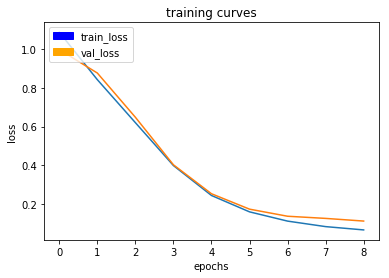

40/40 [==============================] - 140s - loss: 0.0665 - val_loss: 0.1122
Epoch 10/100
39/40 [============================>.] - ETA: 3s - loss: 0.0548

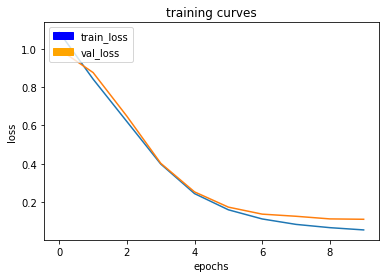

40/40 [==============================] - 143s - loss: 0.0548 - val_loss: 0.1103
Epoch 11/100
39/40 [============================>.] - ETA: 3s - loss: 0.0459

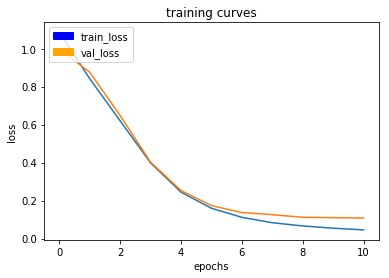

40/40 [==============================] - 139s - loss: 0.0458 - val_loss: 0.1084
Epoch 12/100
39/40 [============================>.] - ETA: 3s - loss: 0.0397

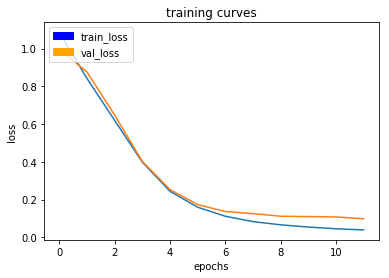

40/40 [==============================] - 140s - loss: 0.0397 - val_loss: 0.0988
Epoch 13/100
39/40 [============================>.] - ETA: 3s - loss: 0.0348

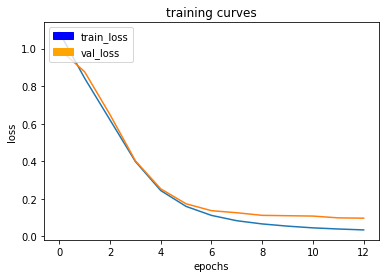

40/40 [==============================] - 142s - loss: 0.0347 - val_loss: 0.0972
Epoch 14/100
39/40 [============================>.] - ETA: 3s - loss: 0.0312

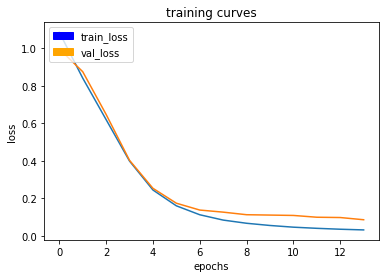

40/40 [==============================] - 139s - loss: 0.0311 - val_loss: 0.0854
Epoch 15/100
39/40 [============================>.] - ETA: 3s - loss: 0.0287

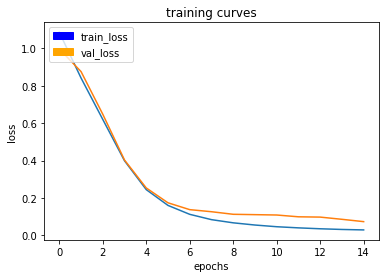

40/40 [==============================] - 140s - loss: 0.0288 - val_loss: 0.0729
Epoch 16/100
39/40 [============================>.] - ETA: 3s - loss: 0.0265

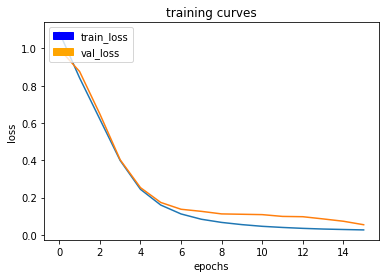

40/40 [==============================] - 142s - loss: 0.0265 - val_loss: 0.0542
Epoch 17/100
39/40 [============================>.] - ETA: 3s - loss: 0.0245

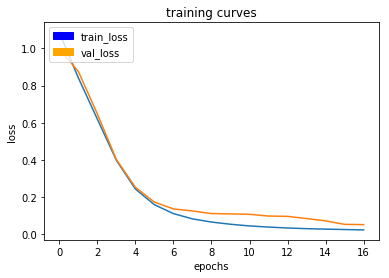

40/40 [==============================] - 139s - loss: 0.0245 - val_loss: 0.0526
Epoch 18/100
39/40 [============================>.] - ETA: 3s - loss: 0.0229

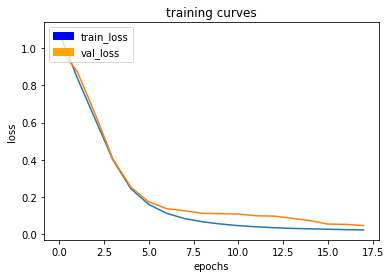

40/40 [==============================] - 140s - loss: 0.0229 - val_loss: 0.0463
Epoch 19/100
39/40 [============================>.] - ETA: 3s - loss: 0.0216

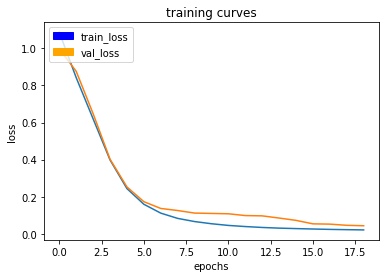

40/40 [==============================] - 142s - loss: 0.0215 - val_loss: 0.0440
Epoch 20/100
39/40 [============================>.] - ETA: 3s - loss: 0.0199

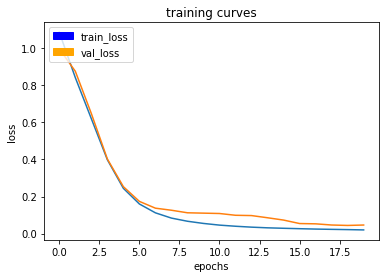

40/40 [==============================] - 140s - loss: 0.0199 - val_loss: 0.0462
Epoch 21/100
39/40 [============================>.] - ETA: 3s - loss: 0.0191

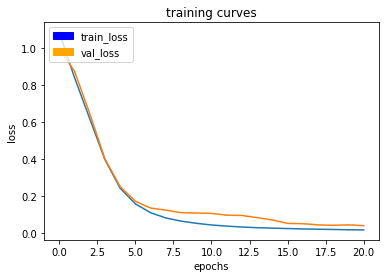

40/40 [==============================] - 140s - loss: 0.0191 - val_loss: 0.0424
Epoch 22/100
39/40 [============================>.] - ETA: 3s - loss: 0.0187

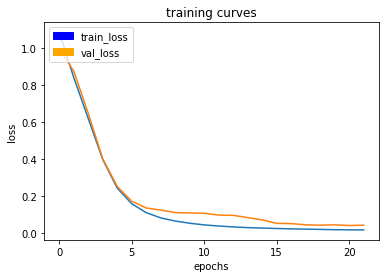

40/40 [==============================] - 143s - loss: 0.0187 - val_loss: 0.0442
Epoch 23/100
39/40 [============================>.] - ETA: 3s - loss: 0.0178

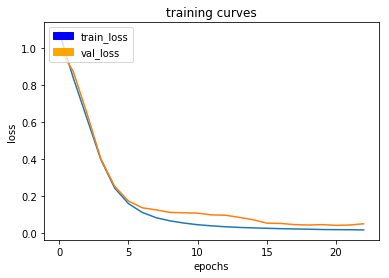

40/40 [==============================] - 140s - loss: 0.0178 - val_loss: 0.0509
Epoch 24/100
39/40 [============================>.] - ETA: 3s - loss: 0.0169

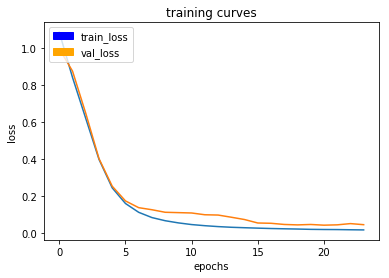

40/40 [==============================] - 139s - loss: 0.0169 - val_loss: 0.0450
Epoch 25/100
39/40 [============================>.] - ETA: 3s - loss: 0.0161

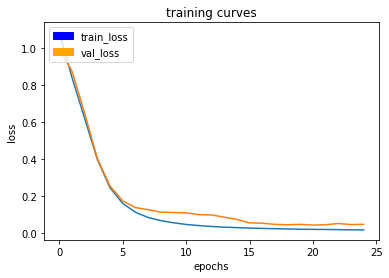

40/40 [==============================] - 142s - loss: 0.0161 - val_loss: 0.0466
Epoch 26/100
39/40 [============================>.] - ETA: 3s - loss: 0.0157

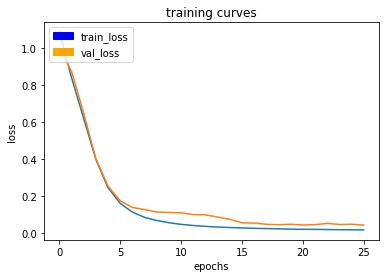

40/40 [==============================] - 140s - loss: 0.0156 - val_loss: 0.0415
Epoch 27/100
39/40 [============================>.] - ETA: 3s - loss: 0.0151

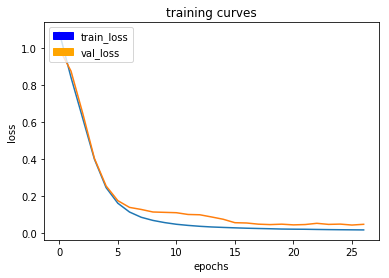

40/40 [==============================] - 140s - loss: 0.0151 - val_loss: 0.0455
Epoch 28/100
39/40 [============================>.] - ETA: 3s - loss: 0.0148

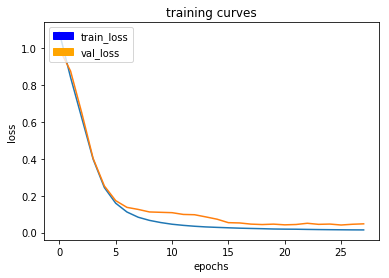

40/40 [==============================] - 143s - loss: 0.0148 - val_loss: 0.0478
Epoch 29/100
39/40 [============================>.] - ETA: 3s - loss: 0.0143

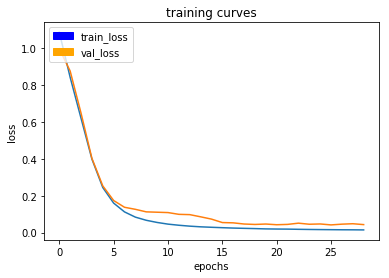

40/40 [==============================] - 140s - loss: 0.0143 - val_loss: 0.0431
Epoch 30/100
39/40 [============================>.] - ETA: 3s - loss: 0.0145

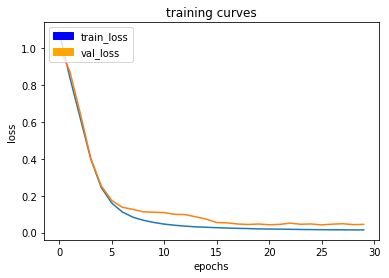

40/40 [==============================] - 140s - loss: 0.0145 - val_loss: 0.0443
Epoch 31/100
39/40 [============================>.] - ETA: 3s - loss: 0.0136

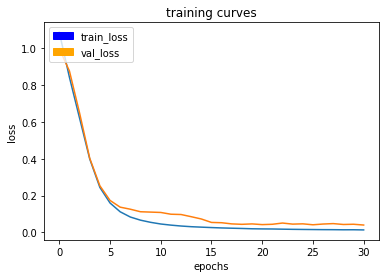

40/40 [==============================] - 143s - loss: 0.0136 - val_loss: 0.0401
Epoch 32/100
39/40 [============================>.] - ETA: 3s - loss: 0.0133

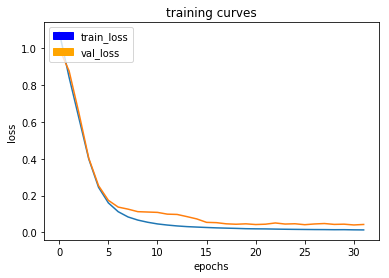

40/40 [==============================] - 140s - loss: 0.0133 - val_loss: 0.0428
Epoch 33/100
39/40 [============================>.] - ETA: 3s - loss: 0.0131

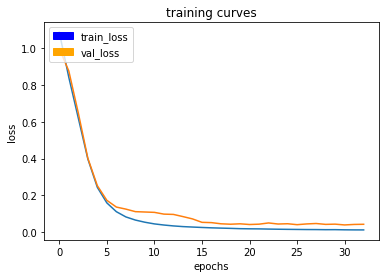

40/40 [==============================] - 140s - loss: 0.0131 - val_loss: 0.0436
Epoch 34/100
39/40 [============================>.] - ETA: 3s - loss: 0.0127

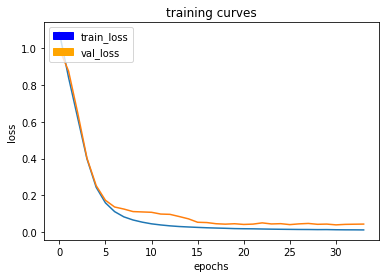

40/40 [==============================] - 143s - loss: 0.0127 - val_loss: 0.0443
Epoch 35/100
39/40 [============================>.] - ETA: 3s - loss: 0.0126

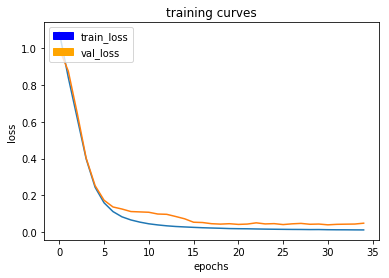

40/40 [==============================] - 140s - loss: 0.0126 - val_loss: 0.0490
Epoch 36/100
39/40 [============================>.] - ETA: 3s - loss: 0.0125

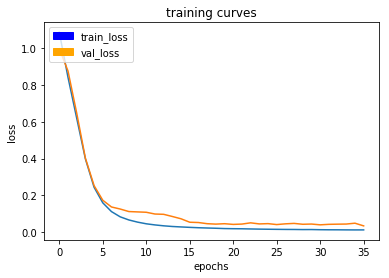

40/40 [==============================] - 140s - loss: 0.0125 - val_loss: 0.0343
Epoch 37/100
39/40 [============================>.] - ETA: 3s - loss: 0.0121

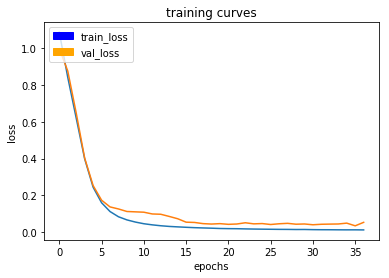

40/40 [==============================] - 143s - loss: 0.0121 - val_loss: 0.0532
Epoch 38/100
39/40 [============================>.] - ETA: 3s - loss: 0.0118

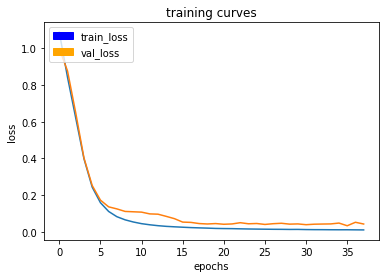

40/40 [==============================] - 139s - loss: 0.0118 - val_loss: 0.0438
Epoch 39/100
39/40 [============================>.] - ETA: 3s - loss: 0.0114

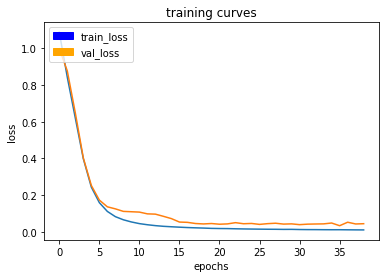

40/40 [==============================] - 140s - loss: 0.0115 - val_loss: 0.0452
Epoch 40/100
39/40 [============================>.] - ETA: 3s - loss: 0.0112

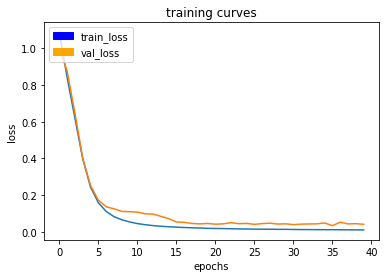

40/40 [==============================] - 143s - loss: 0.0113 - val_loss: 0.0417
Epoch 41/100
39/40 [============================>.] - ETA: 3s - loss: 0.0115

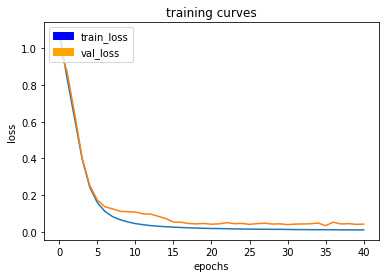

40/40 [==============================] - 140s - loss: 0.0115 - val_loss: 0.0426
Epoch 42/100
39/40 [============================>.] - ETA: 3s - loss: 0.0112

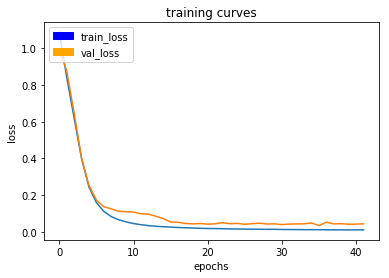

40/40 [==============================] - 139s - loss: 0.0112 - val_loss: 0.0445
Epoch 43/100
39/40 [============================>.] - ETA: 3s - loss: 0.0109

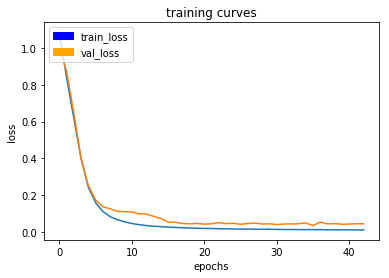

40/40 [==============================] - 143s - loss: 0.0109 - val_loss: 0.0443
Epoch 44/100
39/40 [============================>.] - ETA: 3s - loss: 0.0106

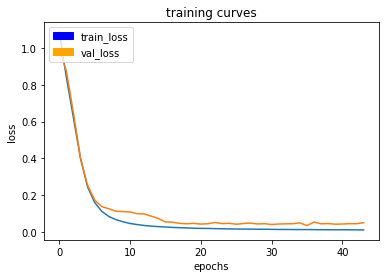

40/40 [==============================] - 140s - loss: 0.0106 - val_loss: 0.0500
Epoch 45/100
39/40 [============================>.] - ETA: 3s - loss: 0.0106

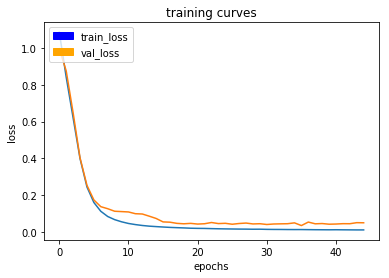

40/40 [==============================] - 139s - loss: 0.0106 - val_loss: 0.0494
Epoch 46/100
39/40 [============================>.] - ETA: 3s - loss: 0.0198

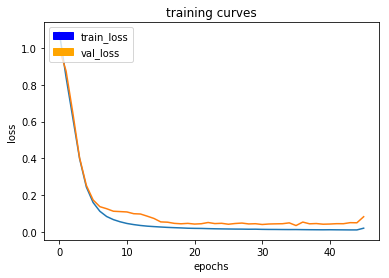

40/40 [==============================] - 143s - loss: 0.0198 - val_loss: 0.0824
Epoch 47/100
39/40 [============================>.] - ETA: 3s - loss: 0.0154

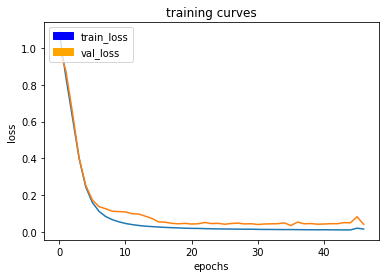

40/40 [==============================] - 140s - loss: 0.0153 - val_loss: 0.0407
Epoch 48/100
39/40 [============================>.] - ETA: 3s - loss: 0.0128

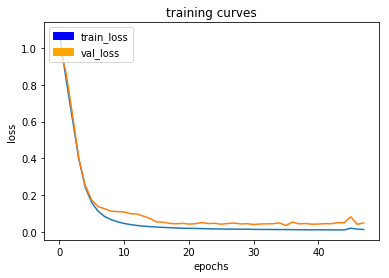

40/40 [==============================] - 140s - loss: 0.0128 - val_loss: 0.0490
Epoch 49/100
39/40 [============================>.] - ETA: 3s - loss: 0.0114

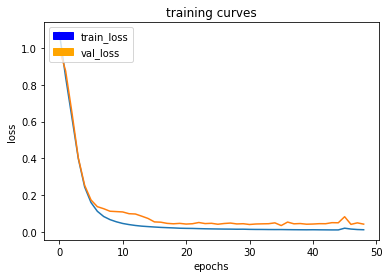

40/40 [==============================] - 143s - loss: 0.0114 - val_loss: 0.0421
Epoch 50/100
39/40 [============================>.] - ETA: 3s - loss: 0.0109

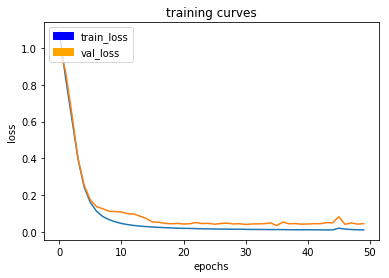

40/40 [==============================] - 139s - loss: 0.0109 - val_loss: 0.0450
Epoch 51/100
39/40 [============================>.] - ETA: 3s - loss: 0.0106

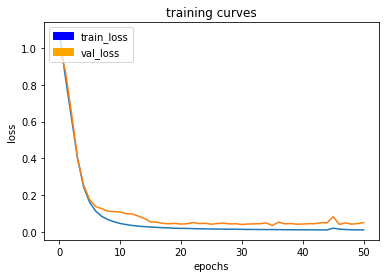

40/40 [==============================] - 140s - loss: 0.0106 - val_loss: 0.0506
Epoch 52/100
39/40 [============================>.] - ETA: 3s - loss: 0.0106

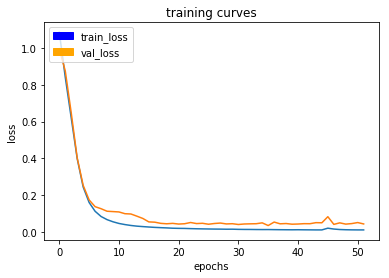

40/40 [==============================] - 142s - loss: 0.0106 - val_loss: 0.0431
Epoch 53/100
39/40 [============================>.] - ETA: 3s - loss: 0.0111

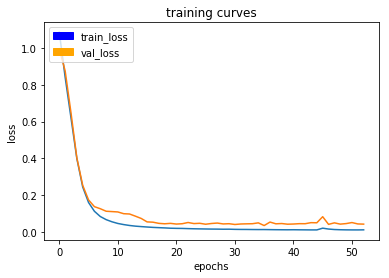

40/40 [==============================] - 140s - loss: 0.0111 - val_loss: 0.0420
Epoch 54/100
39/40 [============================>.] - ETA: 3s - loss: 0.0101

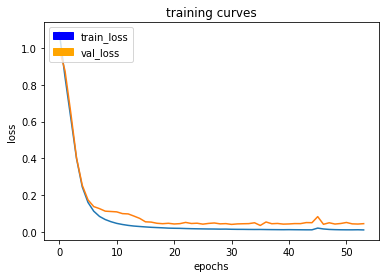

40/40 [==============================] - 140s - loss: 0.0101 - val_loss: 0.0441
Epoch 55/100
39/40 [============================>.] - ETA: 3s - loss: 0.0099

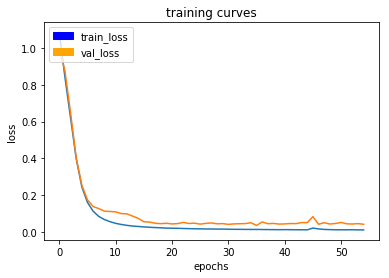

40/40 [==============================] - 143s - loss: 0.0099 - val_loss: 0.0406
Epoch 56/100
39/40 [============================>.] - ETA: 3s - loss: 0.0101

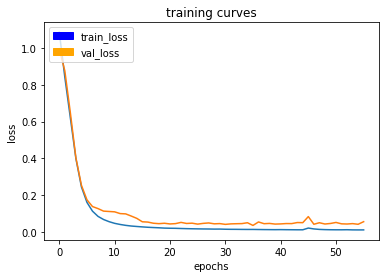

40/40 [==============================] - 139s - loss: 0.0101 - val_loss: 0.0548
Epoch 57/100
39/40 [============================>.] - ETA: 3s - loss: 0.0094

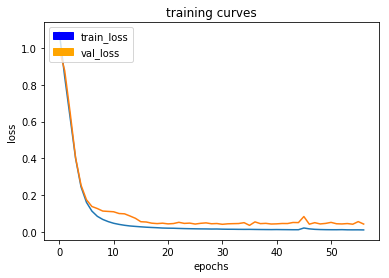

40/40 [==============================] - 140s - loss: 0.0094 - val_loss: 0.0414
Epoch 58/100
39/40 [============================>.] - ETA: 3s - loss: 0.0093

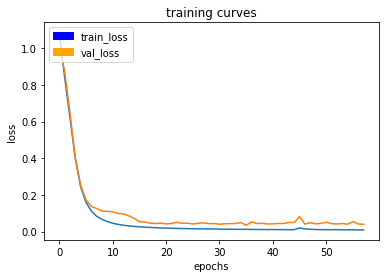

40/40 [==============================] - 143s - loss: 0.0093 - val_loss: 0.0401
Epoch 59/100
39/40 [============================>.] - ETA: 3s - loss: 0.0093

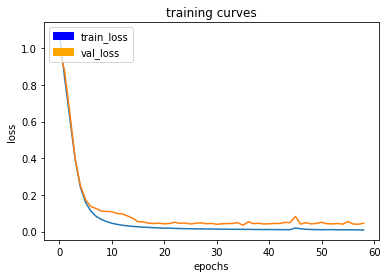

40/40 [==============================] - 139s - loss: 0.0093 - val_loss: 0.0460
Epoch 60/100
39/40 [============================>.] - ETA: 3s - loss: 0.0092

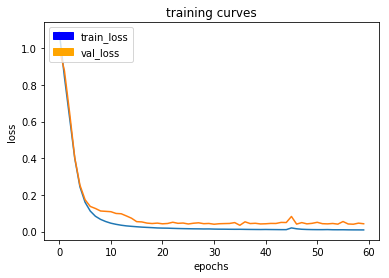

40/40 [==============================] - 140s - loss: 0.0092 - val_loss: 0.0427
Epoch 61/100
39/40 [============================>.] - ETA: 3s - loss: 0.0091

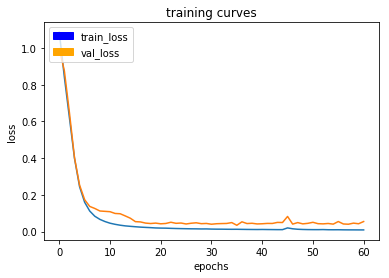

40/40 [==============================] - 143s - loss: 0.0091 - val_loss: 0.0548
Epoch 62/100
39/40 [============================>.] - ETA: 3s - loss: 0.0090

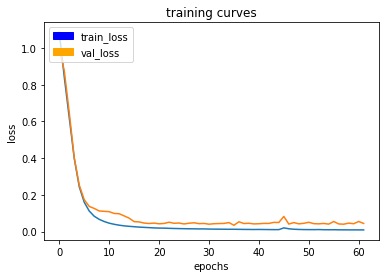

40/40 [==============================] - 140s - loss: 0.0090 - val_loss: 0.0443
Epoch 63/100
39/40 [============================>.] - ETA: 3s - loss: 0.0094

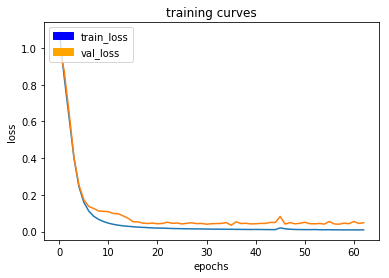

40/40 [==============================] - 140s - loss: 0.0094 - val_loss: 0.0482
Epoch 64/100
39/40 [============================>.] - ETA: 3s - loss: 0.0089

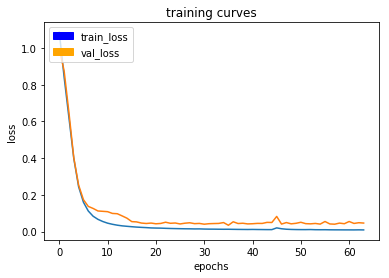

40/40 [==============================] - 142s - loss: 0.0089 - val_loss: 0.0463
Epoch 65/100
39/40 [============================>.] - ETA: 3s - loss: 0.0087

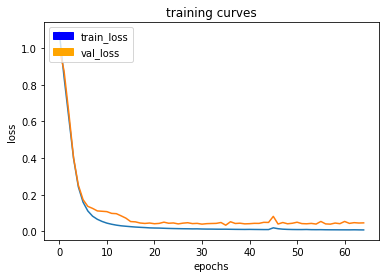

40/40 [==============================] - 140s - loss: 0.0087 - val_loss: 0.0470
Epoch 66/100
39/40 [============================>.] - ETA: 3s - loss: 0.0086

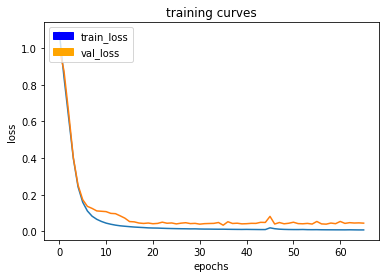

40/40 [==============================] - 140s - loss: 0.0086 - val_loss: 0.0455
Epoch 67/100
39/40 [============================>.] - ETA: 3s - loss: 0.0086

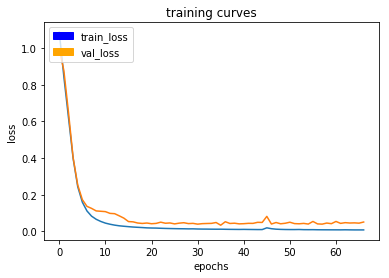

40/40 [==============================] - 143s - loss: 0.0086 - val_loss: 0.0516
Epoch 68/100
39/40 [============================>.] - ETA: 3s - loss: 0.0084

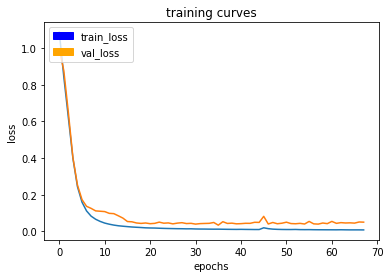

40/40 [==============================] - 140s - loss: 0.0084 - val_loss: 0.0507
Epoch 69/100
39/40 [============================>.] - ETA: 3s - loss: 0.0084

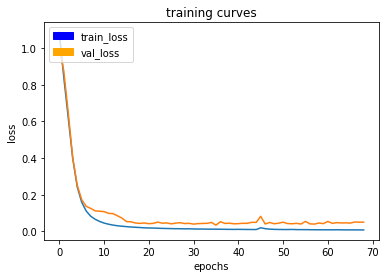

40/40 [==============================] - 140s - loss: 0.0084 - val_loss: 0.0507
Epoch 70/100
39/40 [============================>.] - ETA: 3s - loss: 0.0084

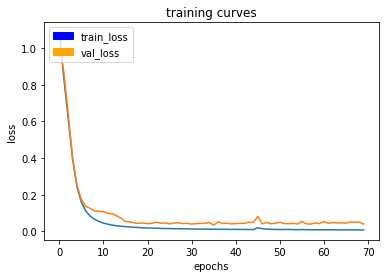

40/40 [==============================] - 142s - loss: 0.0084 - val_loss: 0.0397
Epoch 71/100
39/40 [============================>.] - ETA: 3s - loss: 0.0082

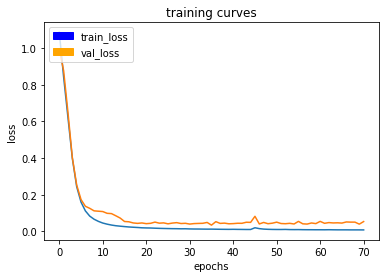

40/40 [==============================] - 140s - loss: 0.0082 - val_loss: 0.0538
Epoch 72/100
39/40 [============================>.] - ETA: 3s - loss: 0.0081

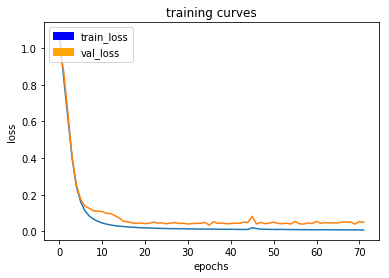

40/40 [==============================] - 140s - loss: 0.0081 - val_loss: 0.0497
Epoch 73/100
39/40 [============================>.] - ETA: 3s - loss: 0.0080

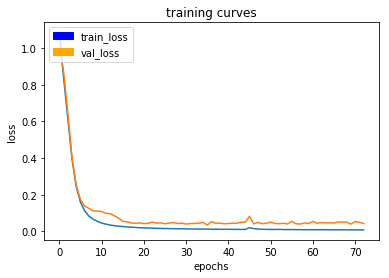

40/40 [==============================] - 143s - loss: 0.0080 - val_loss: 0.0426
Epoch 74/100
39/40 [============================>.] - ETA: 3s - loss: 0.0079

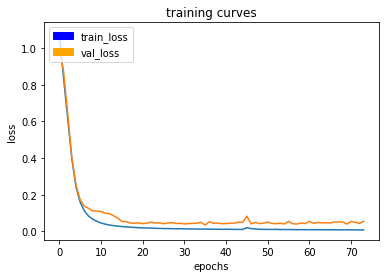

40/40 [==============================] - 140s - loss: 0.0079 - val_loss: 0.0552
Epoch 75/100
39/40 [============================>.] - ETA: 3s - loss: 0.0081

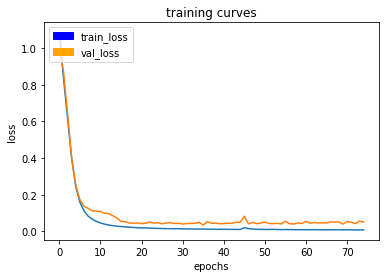

40/40 [==============================] - 140s - loss: 0.0081 - val_loss: 0.0504
Epoch 76/100
39/40 [============================>.] - ETA: 3s - loss: 0.0080

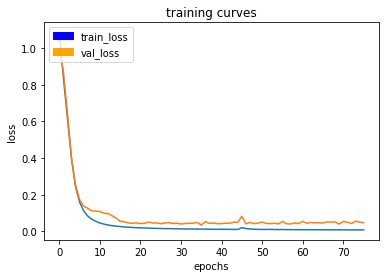

40/40 [==============================] - 143s - loss: 0.0080 - val_loss: 0.0473
Epoch 77/100
39/40 [============================>.] - ETA: 3s - loss: 0.0081

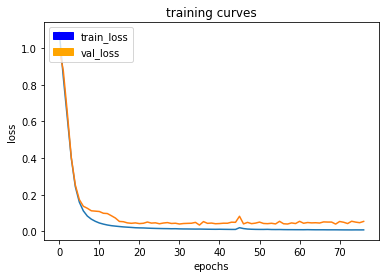

40/40 [==============================] - 140s - loss: 0.0081 - val_loss: 0.0543
Epoch 78/100
39/40 [============================>.] - ETA: 3s - loss: 0.0079

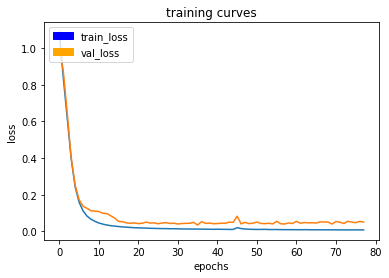

40/40 [==============================] - 140s - loss: 0.0079 - val_loss: 0.0505
Epoch 79/100
39/40 [============================>.] - ETA: 3s - loss: 0.0080

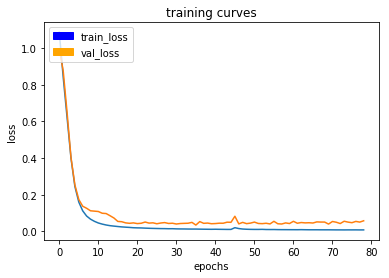

40/40 [==============================] - 143s - loss: 0.0080 - val_loss: 0.0577
Epoch 80/100
39/40 [============================>.] - ETA: 3s - loss: 0.0079

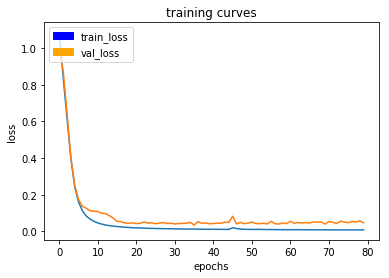

40/40 [==============================] - 139s - loss: 0.0079 - val_loss: 0.0463
Epoch 81/100
39/40 [============================>.] - ETA: 3s - loss: 0.0078

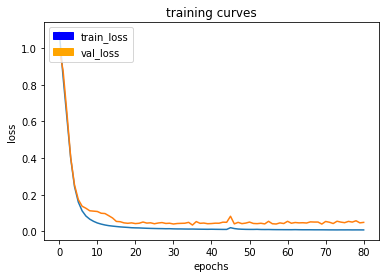

40/40 [==============================] - 140s - loss: 0.0078 - val_loss: 0.0489
Epoch 82/100
39/40 [============================>.] - ETA: 3s - loss: 0.0077

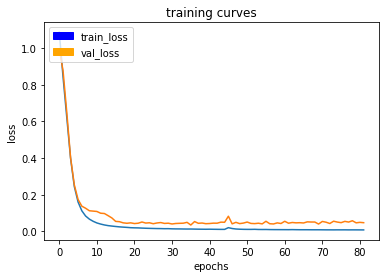

40/40 [==============================] - 143s - loss: 0.0077 - val_loss: 0.0471
Epoch 83/100
39/40 [============================>.] - ETA: 3s - loss: 0.0076

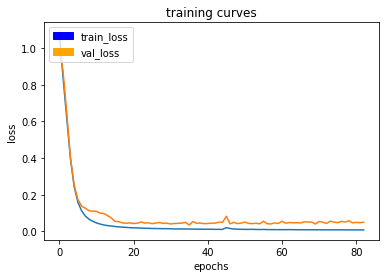

40/40 [==============================] - 140s - loss: 0.0076 - val_loss: 0.0498
Epoch 84/100
39/40 [============================>.] - ETA: 3s - loss: 0.0077

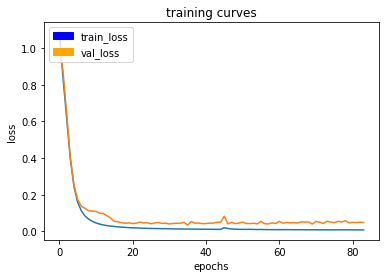

40/40 [==============================] - 140s - loss: 0.0077 - val_loss: 0.0479
Epoch 85/100
39/40 [============================>.] - ETA: 3s - loss: 0.0078

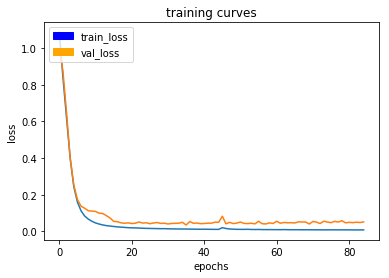

40/40 [==============================] - 142s - loss: 0.0078 - val_loss: 0.0513
Epoch 86/100
39/40 [============================>.] - ETA: 3s - loss: 0.0076

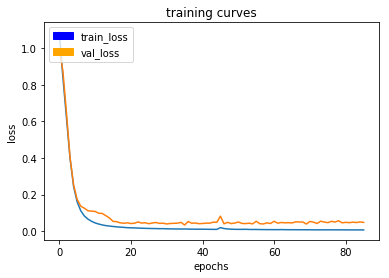

40/40 [==============================] - 140s - loss: 0.0076 - val_loss: 0.0485
Epoch 87/100
39/40 [============================>.] - ETA: 3s - loss: 0.0076

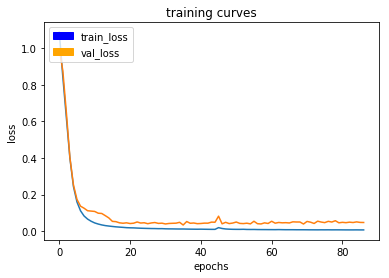

40/40 [==============================] - 140s - loss: 0.0076 - val_loss: 0.0481
Epoch 88/100
39/40 [============================>.] - ETA: 3s - loss: 0.0074

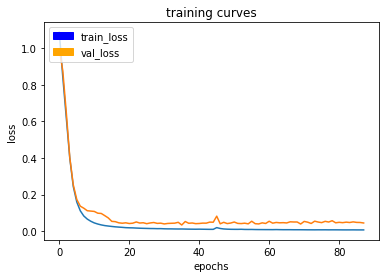

40/40 [==============================] - 143s - loss: 0.0074 - val_loss: 0.0452
Epoch 89/100
39/40 [============================>.] - ETA: 3s - loss: 0.0074

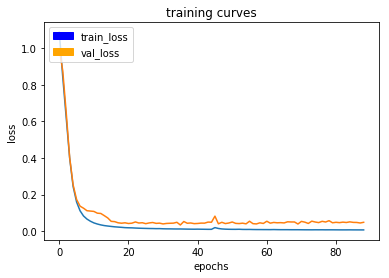

40/40 [==============================] - 139s - loss: 0.0074 - val_loss: 0.0490
Epoch 90/100
39/40 [============================>.] - ETA: 3s - loss: 0.0073

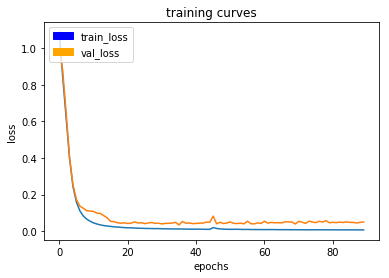

40/40 [==============================] - 140s - loss: 0.0073 - val_loss: 0.0509
Epoch 91/100
39/40 [============================>.] - ETA: 3s - loss: 0.0074

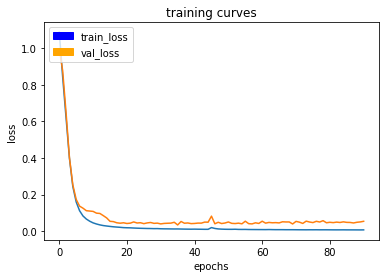

40/40 [==============================] - 143s - loss: 0.0075 - val_loss: 0.0543
Epoch 92/100
39/40 [============================>.] - ETA: 3s - loss: 0.0073

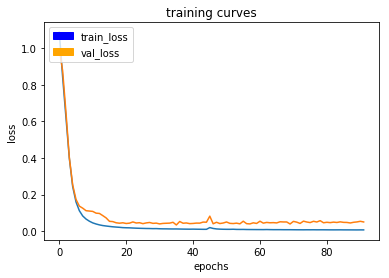

40/40 [==============================] - 140s - loss: 0.0074 - val_loss: 0.0507
Epoch 93/100
39/40 [============================>.] - ETA: 3s - loss: 0.0075

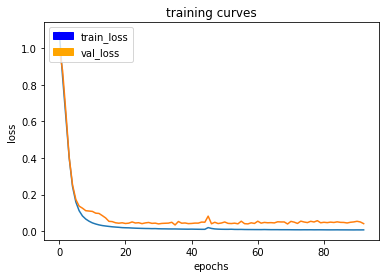

40/40 [==============================] - 140s - loss: 0.0075 - val_loss: 0.0415
Epoch 94/100
39/40 [============================>.] - ETA: 3s - loss: 0.0074

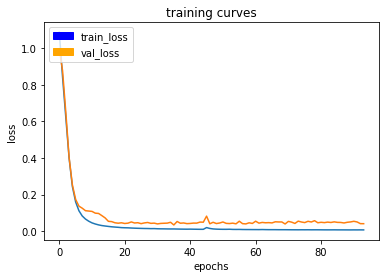

40/40 [==============================] - 143s - loss: 0.0074 - val_loss: 0.0413
Epoch 95/100
39/40 [============================>.] - ETA: 3s - loss: 0.0073

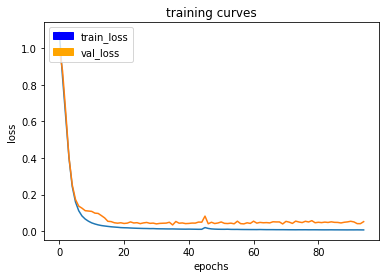

40/40 [==============================] - 140s - loss: 0.0072 - val_loss: 0.0523
Epoch 96/100
39/40 [============================>.] - ETA: 3s - loss: 0.0072

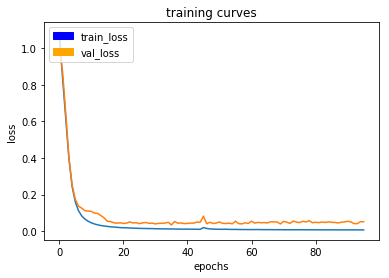

40/40 [==============================] - 140s - loss: 0.0072 - val_loss: 0.0516
Epoch 97/100
39/40 [============================>.] - ETA: 3s - loss: 0.0080

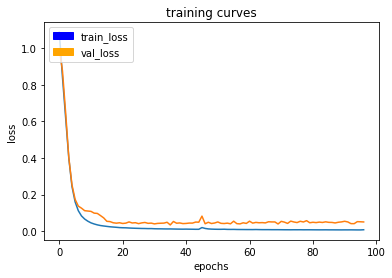

40/40 [==============================] - 143s - loss: 0.0081 - val_loss: 0.0506
Epoch 98/100
39/40 [============================>.] - ETA: 3s - loss: 0.0079

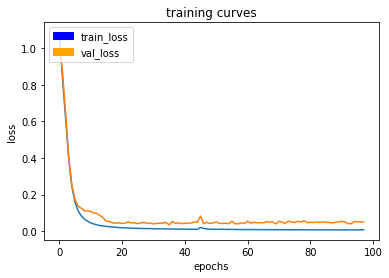

40/40 [==============================] - 140s - loss: 0.0079 - val_loss: 0.0505
Epoch 99/100
39/40 [============================>.] - ETA: 3s - loss: 0.0073

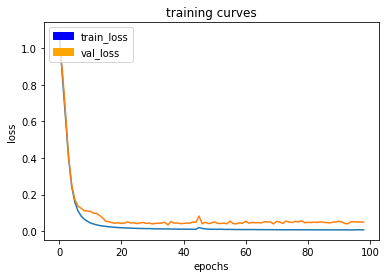

40/40 [==============================] - 140s - loss: 0.0073 - val_loss: 0.0497
Epoch 100/100
39/40 [============================>.] - ETA: 3s - loss: 0.0071

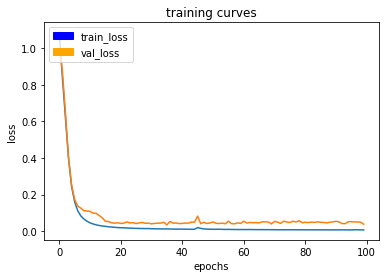

40/40 [==============================] - 143s - loss: 0.0071 - val_loss: 0.0380


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

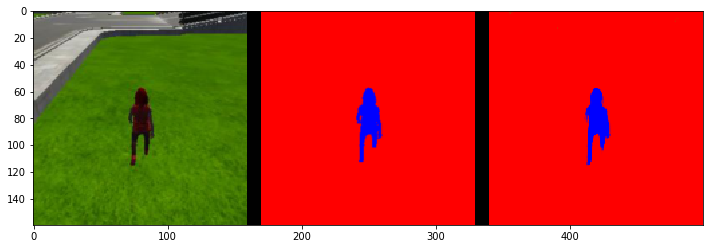

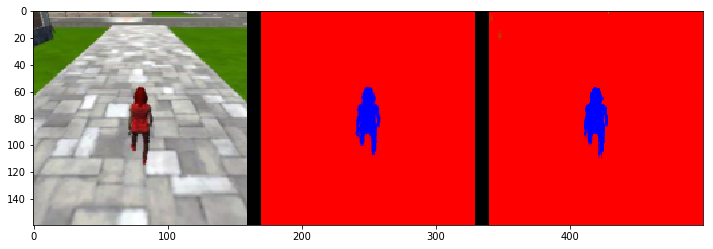

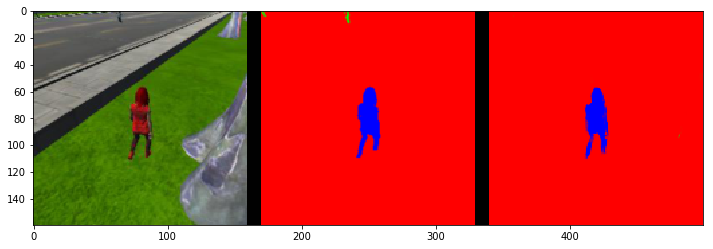

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

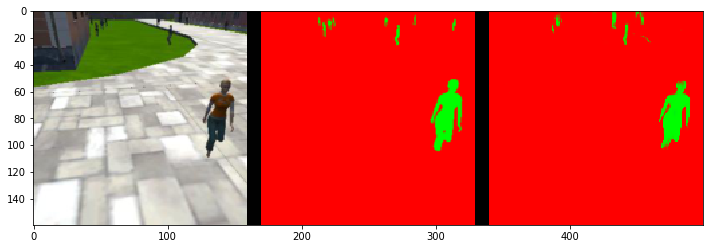

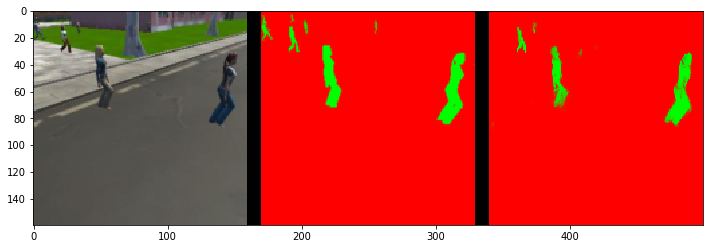

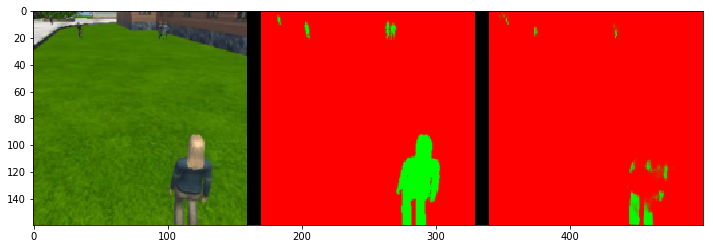

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

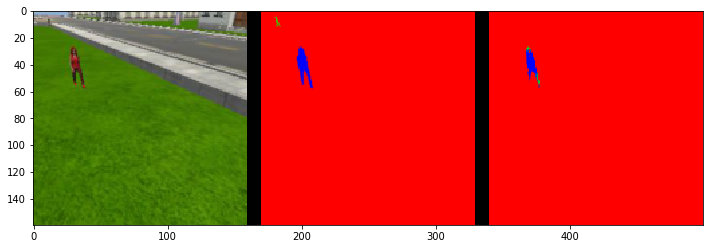

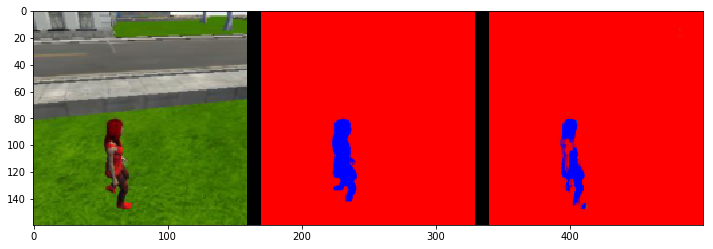

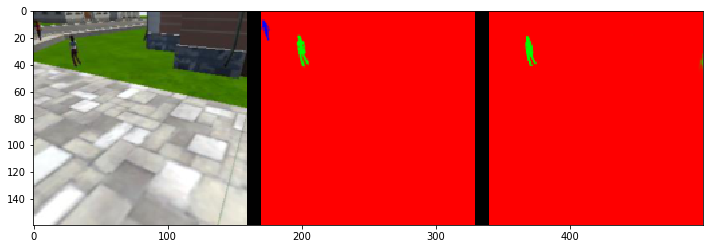

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9940778044266324
average intersection over union for other people is 0.24590901658248213
average intersection over union for the hero is 0.892943322303819
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9785078141158893
average intersection over union for other people is 0.5540473632859025
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 70, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9942484525125391
average intersection over union for other people is 0.2915995147649284
average intersection over union for the hero is 0.0654086066713878
number true positives: 52, number false positives: 0, number false negatives: 249


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6494505494505495


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.479175964488


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.31120109342
